In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import RidgeClassifierCV, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

from scipy.fft import fft

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.optimizers import Adam

from tqdm.notebook import tqdm
from tqdm.keras import TqdmCallback

import features
import plots

2022-12-18 12:42:54.964476: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-18 12:42:55.317899: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-12-18 12:42:55.317949: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-12-18 12:42:57.052488: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2022-

In [2]:
data_folder = 'data/csv/'
data_files = ['10101.smo.csv']

useRaw = False
test_size = 0.3
seed = 13
window_sizes = [2, 5, 10, 50, 100]
days = [0, 1, 2, 3]
cat_matrix = True # True for neural net, any for random forest

In [3]:
df = features.load_features(data_folder, data_files)

window_features = ["EEGv", "EMGv"]
window_names = []

for window_size in window_sizes:
    df = features.features_window(df, window_size=window_size, op=features.WindowOperationFlag.MEAN, features=window_features)
    df = features.features_window(df, window_size=window_size, op=features.WindowOperationFlag.VAR, features=window_features)

    for feature in window_features:
        window_names.append(feature + "_mean" + str(window_size))
        window_names.append(feature + "_var" + str(window_size))

df = features.log_features(df, ["EEGv", "EMGv"] + window_names)

df = df.dropna()
df = features.add_times(df)
df = features.filter_days(df, days)

skeep, _ = features.states(useRaw)

In [4]:
df1 = df.copy()
# drop bin0 to bin400
for i in range(401):
    df1 = df1.drop([f"bin{i}"], axis=1)

print(df1[skeep].value_counts())
balance = df[skeep].value_counts().min()
# keep same amount of each class
df1 = df1.groupby(skeep).apply(lambda x: x.sample(balance)).reset_index(drop=True)

print(df1[skeep].value_counts())

print(df1.shape)
print(df1.columns)

w    48651
n    33955
r     3695
Name: state, dtype: int64
n    3695
r    3695
w    3695
Name: state, dtype: int64
(11085, 49)
Index(['rawState', 'state', 'EEGv', 'EMGv', 'temp', 'EEGv_mean2', 'EMGv_mean2',
       'EEGv_var2', 'EMGv_var2', 'EEGv_mean5', 'EMGv_mean5', 'EEGv_var5',
       'EMGv_var5', 'EEGv_mean10', 'EMGv_mean10', 'EEGv_var10', 'EMGv_var10',
       'EEGv_mean50', 'EMGv_mean50', 'EEGv_var50', 'EMGv_var50',
       'EEGv_mean100', 'EMGv_mean100', 'EEGv_var100', 'EMGv_var100',
       'EEGv_log', 'EMGv_log', 'EEGv_mean2_log', 'EMGv_mean2_log',
       'EEGv_var2_log', 'EMGv_var2_log', 'EEGv_mean5_log', 'EMGv_mean5_log',
       'EEGv_var5_log', 'EMGv_var5_log', 'EEGv_mean10_log', 'EMGv_mean10_log',
       'EEGv_var10_log', 'EMGv_var10_log', 'EEGv_mean50_log',
       'EMGv_mean50_log', 'EEGv_var50_log', 'EMGv_var50_log',
       'EEGv_mean100_log', 'EMGv_mean100_log', 'EEGv_var100_log',
       'EMGv_var100_log', 'time', 'day'],
      dtype='object')


In [5]:
x_train, x_test, y_train, y_test, le = features.split_data(df1, useRaw, test_size, seed, cat_matrix)

# Random Forest

[[1038   51   16]
 [  84 1062    6]
 [  28   22 1019]]
              precision    recall  f1-score   support

           n       0.90      0.94      0.92      1105
           r       0.94      0.92      0.93      1152
           w       0.98      0.95      0.97      1069

    accuracy                           0.94      3326
   macro avg       0.94      0.94      0.94      3326
weighted avg       0.94      0.94      0.94      3326



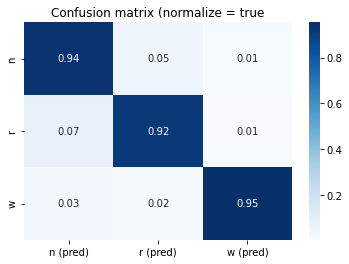

"Score": 0.928141912206855


In [6]:
rfc = RandomForestClassifier(random_state=seed)
rfc.fit(x_train, y_train)
y_predict = rfc.predict(x_test)

plots.plot_confusion(model=rfc, x_test=x_test, y_test=y_test, le=le, cat_matrix=cat_matrix, normalize='true')
print(f'\"Score\": {rfc.score(x_test, y_test)}')

# Neural Network

In [7]:
def baseline_model(input_dim, num_classes, lr=0.001):
    model = Sequential()
    model.add(Dense(128, input_dim=input_dim, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(16, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(8, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(num_classes, activation='softmax'))

    model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=lr), metrics=['accuracy'])

    return model

model = baseline_model(x_train.shape[1], le.classes_.size)
model.summary()

2022-12-18 12:43:52.664897: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-12-18 12:43:52.664955: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2022-12-18 12:43:52.664993: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (Black-Gold-Elementary): /proc/driver/nvidia/version does not exist
2022-12-18 12:43:52.665475: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               5760      
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 32)                2080      
                                                                 
 dropout_2 (Dropout)         (None, 32)                0         
                                                                 
 dense_3 (Dense)             (None, 16)                5

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

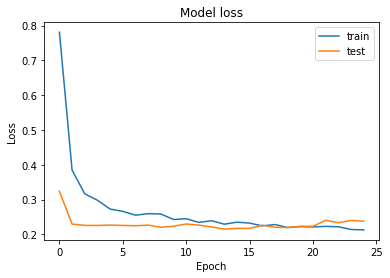

In [8]:
history = model.fit(x=x_train,
                    y=y_train,
                    validation_data=(x_test, y_test),
                    epochs=25,
                    batch_size=100,
                    verbose=0,
                    callbacks=[TqdmCallback(verbose=1)]
                )

plots.plot_loss(history.history)

104/104 [==============================] - 1s 3ms/step
[[1000   88   17]
 [  45 1091   16]
 [  16   27 1026]]
              precision    recall  f1-score   support

           n       0.94      0.90      0.92      1105
           r       0.90      0.95      0.93      1152
           w       0.97      0.96      0.96      1069

    accuracy                           0.94      3326
   macro avg       0.94      0.94      0.94      3326
weighted avg       0.94      0.94      0.94      3326



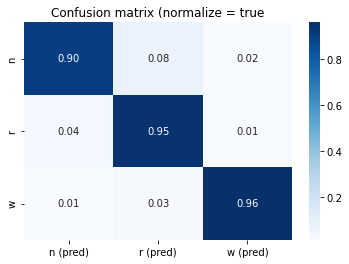

In [9]:
plots.plot_confusion(model=model, x_test=x_test, y_test=y_test, le=le, cat_matrix=True, normalize='true')

In [10]:
def show_x():
    bins = list(map(lambda x: f"bin{x}", range(401)))
    df_bins = df[bins].copy()

    # sum first column to rest
    query = df.query("state == 'w'")[bins[1:101]]

    fig, axs = plt.subplots(5, 5, figsize=(25, 25))
    for i in range(5):
        for j in range(5):
            query.iloc[i*5+j].plot(ax=axs[i, j])

    plt.show()